# Project: Dynamics of Bargaining Pwer
# Dynamics of bargaining power (Simulation)

#### Genaro, Itza, Sonia
#### June 2021 

This code was made specifically to simulate a contract with the dynamic multi-objective model of principal-agent proposed by ... 

## Libraries

In [5]:
using DataFrames
using XLSX
using ExcelFiles  # Loading excel files libraries.
using Random
using Plots,Plots.PlotMeasures 
using Colors, ColorSchemes
using Statistics
using HypothesisTests
using Serialization

## Utility Functions

In [6]:
#v(c,a,g=1,alpha=1)=-exp(g*(a-alpha*c))  # Declaration of v (agent utility function); 
                                        # g is the coefficient of risk aversion
                                        # alpha is a cost coefficientv

v(c, a, h=0.5) =  c^(1-h)/(1-h)- a #CRA Function 
                                    #h is a oefficient of risk aversion
                                    # a is the agent effort
u(y,w)=y-w  #Declaration of the principal utility function 
            #y is the current output
            #w is the salary paid to the agent
paretocdf(a,L,H,x) = (1-(L/x)^(a))/(1-(L/H)^a)

paretocdf (generic function with 1 method)

## Variables and Lists

In [7]:
A = [0.1 1]    # Actions set [al ah]
Y = [0.4 0.8]    # Outcomes set [yl yh]
co = 2 #Coefficient Yh/Yl
beta = 0.96    # Future discount factor
h = 0.5 #Risk AdversionParameter for agent utility 
eps = 0.01 #Dynamic of the bargaining power parameter 
Est_point = DataFrame(XLSX.readtable("Data/ModTesis_eps001_y0408_h05.xlsx", "Sheet1")...) #Data of the optimal contracts
d0 = 361 #Initial index of the contract - change for simulation
n = size(Est_point)[1] #Dataframe lenght
N = 100 #Number of periods to simulate
min_delta = Est_point[1, "Deltas"]
max_delta = Est_point[n, "Deltas"]

0.395

In [8]:
Est_point[361, "Deltas"]

0.19999999999999998

## Output Simulation Function

In [9]:
function output(a)
    """
    This functions simulates an output given an effort level. 
    Returns output 
    """
    y = 0
    r = rand()
    f = paretocdf(a,Y[1],Y[2],(Y[1]+Y[2])/2)
    if r<f
        y = Y[2]
    else 
        y = Y[1]
    end
    return y
end

output (generic function with 1 method)

## One step Simulation 

In [10]:
function sim_one_period(d)
    """
    This functions simulates one period in the contract given an initial level d.
    Returns current period compensation, action and output; next period delta and promised utilities. 
    """
    a = Est_point[d,"Accion_Recomendada"]
    y = output(a)
    comp = 0
    
    if y == Y[1]
        comp = Est_point[d, "Compensacion_YL"]
        d = max(d-1, 1)    
    else 
        comp = Est_point[d, "Compensacion_YH"]
        d = min(d+co, n)
    end
    ag_ut = v(comp, a, h) 
    pr_ut = u(y, comp) 
    return d, y, a, comp, ag_ut, pr_ut
end

sim_one_period (generic function with 1 method)

## Simulation of the contract.

In [11]:
function run_sim(d, N)
    """
    This functions simulates a number (N) of contract periods.  
    Returns simulation data with implemented effort levels, 
    bargaining powers,outputs and compentations. 
    """
    Ac = []
    Deltas = []
    Out = []
    Comps = []
    Agent = []
    Principal = []
    disc_ag = 0 
    disc_pr = 0
    for i in 1:N
        delta = Est_point[d, "Deltas"]
        d, y, a, comp, ag_ut, pr_ut = sim_one_period(d)
        disc_ag += (beta^(i-1))*ag_ut
        disc_pr += (beta^(i-1))*pr_ut
        append!(Ac, a)
        append!(Deltas, delta)
        append!(Out, y)
        append!(Comps, comp)
        append!(Agent, disc_ag)
        append!(Principal, disc_pr)
    end
    res_sim = DataFrame(
    Deltas = Deltas,
    Effort = Ac,
    Compensations = Comps,
    Outputs = Out, 
    Agent_Utility = Agent, 
    Principal_Utility = Principal)
    return res_sim
end

run_sim (generic function with 1 method)

In [12]:
Simulation_data = run_sim(d0, N)
save("Data/Simulations/Sim_eps001_d20_y0408.xlsx", Simulation_data) #Save data of stationary point to excel

## Simulation until Reaching higher bargaining power

In [17]:
function Max_time(d)
    t = 0
    delta = Est_point[d, "Deltas"]
    while delta != max_delta 
        d, y, a, comp, ag_ut, pr_ut = sim_one_period(d)
        delta = delta = Est_point[d, "Deltas"]
        t += 1
    end
    return t
end

Max_time (generic function with 1 method)

## Monte Carlo Simulation for expected time 

In [18]:
mc_iter = 10000
T = []
for i in 1:mc_iter
    append!(T, Max_time(d0))
end
println("Mean: ", mean(T),"\t std:", std(T))

Mean: 500.4728	 std:42.27847214695333


## Hipotesis Tests

In [40]:
T2 = deserialize("Time_mean_conventional.dat")
UnequalVarianceTTest(Array{Float64}(T), Array{Float64}(T2))

Two sample t-test (unequal variance)
------------------------------------
Population details:
    parameter of interest:   Mean difference
    value under h_0:         0
    point estimate:          109.013
    95% confidence interval: (108.0, 110.0)

Test summary:
    outcome with 95% confidence: reject h_0
    two-sided p-value:           <1e-99

Details:
    number of observations:   [10000,10000]
    t-statistic:              215.357473156115
    degrees of freedom:       17296.652874149255
    empirical standard error: 0.5061941821771632


## Monte Carlo simulation for expected compensation 

In [42]:
function Discounted_comp(d)
    disc_com = 0
    for i in 0:100
        delta = Est_point[d, "Deltas"]
        d, y, a, comp, ag_ut, pr_ut = sim_one_period(d)
        disc_com += y*(beta^i)
    end
    return disc_com
end
mc_iter = 10000
Com = []
for i in 1:mc_iter
    append!(Com, Discounted_comp(d0))
end
println("Mean: ", mean(Com),"\t std:", std(Com))

Mean: 15.676628678735355	 std:0.6999577397553233


In [43]:
Com2 = deserialize("Comp_mean_conventional.dat")
UnequalVarianceTTest(Array{Float64}(Com), Array{Float64}(Com2))

Two sample t-test (unequal variance)
------------------------------------
Population details:
    parameter of interest:   Mean difference
    value under h_0:         0
    point estimate:          -0.717056
    95% confidence interval: (-0.7361, -0.698)

Test summary:
    outcome with 95% confidence: reject h_0
    two-sided p-value:           <1e-99

Details:
    number of observations:   [10000,10000]
    t-statistic:              -73.64630750890892
    degrees of freedom:       19975.395823756287
    empirical standard error: 0.009736487625892042


## Plotting

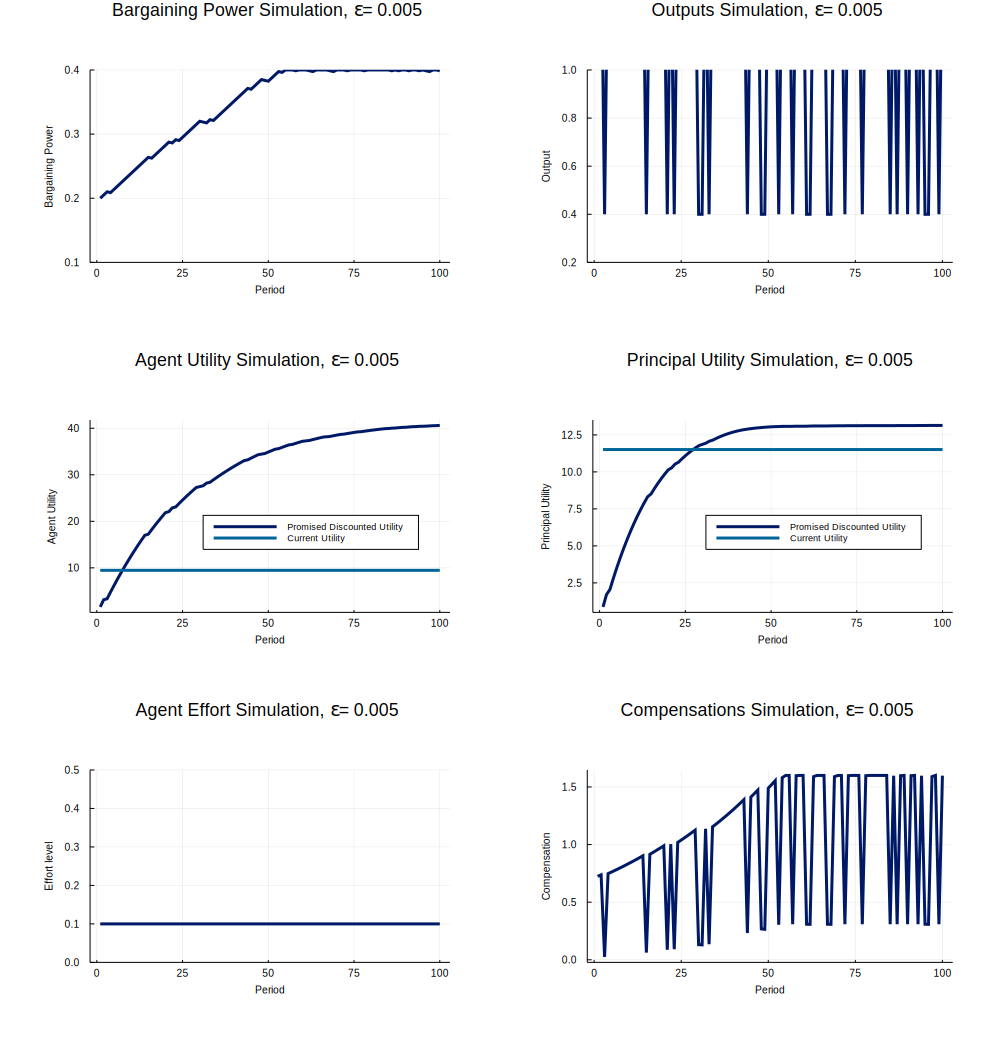

In [207]:
p = get(ColorSchemes.ocean, [0.4,0.6])
#Bargaining power plot.
pl1=plot(Simulation_data[:, "Deltas"],
    legend = false,
    title = string("Bargaining Power Simulation, \\varepsilon = ",repr(eps)),  
    xlabel = "Period",
    ylabel =  "Bargaining Power", 
    ylims=(min_delta, max_delta), 
    linewidth = 3,palette = p)
#display(pl1)
#Effort Plot 
pl2=plot(Simulation_data[:, "Effort"],
    legend = false,
    title = string("Agent Effort Simulation, \\varepsilon = ",repr(eps)),  
    xlabel = "Period",
    ylabel =  "Effort level", 
    ylims=(0,0.5), 
    linewidth = 3,palette = p)
#display(pl2)
#Compensations Plot
pl3=plot(Simulation_data[:, "Compensations"],
    legend = false,
    title = string("Compensations Simulation, \\varepsilon = ",repr(eps)),  
    xlabel = "Period",
    ylabel =  "Compensation", 
    linewidth = 3,palette = p)
#display(pl3)

#Outputs Plot 
pl4=plot(Simulation_data[:, "Outputs"],
    legend = false,
    title = string("Outputs Simulation, \\varepsilon = ",repr(eps)),  
    xlabel = "Period",
    ylims=(0.2,1),
    ylabel =  "Output", 
    linewidth = 3,palette = p)
#display(pl4)

#Agent Utility Plot
pl5= plot([Simulation_data[:, "Agent_Utility"], ones(100)*Est_point[d0, "Utilidad_Agente"]],
    legend = :bottomright, 
    labels = ["Promised Discounted Utility" "Current Utility"],
    title = string("Agent Utility Simulation, \\varepsilon = ",repr(eps)),  
    xlabel = "Period",
    ylabel =  "Agent Utility", 
    linewidth = 3,palette = p)
#display(pl5)
#Principal Utility Plot
pl6 = plot([Simulation_data[:, "Principal_Utility"],ones(100)*Est_point[d0, "Utilidad_Principal"]],
    legend = :bottomright,
    labels = ["Promised Discounted Utility" "Current Utility"],
    title = string("Principal Utility Simulation, \\varepsilon = ",repr(eps)),  
    xlabel = "Period",
    ylabel =  "Principal Utility", 
    linewidth = 3,palette = p)
#display(pl6)
#Layout
l = @layout [a b; c d; e f]

#Figure 
complete_plot = plot(pl1, pl4, pl5, pl6, pl2, pl3, layout = l,
    size = (1000,1050),
    #dpi = 1000,
    xtickfont = font(7), 
    ytickfont = font(7), 
    guidefont = font(7), 
    titlefont = font(12),
    legendfont = font(6),
    markersize = 3,
    margin = 10mm) 
display(complete_plot)
#Save figure 
#savefig("CRA/Bargaining_Dynamic/Simulations/Sim_cra_eps01_d40")